# Imports

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn


from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
#from sklearn.model_selection import KFold

#from pathlib import Path
import PIL
from PIL import Image, ImageOps
import os
import glob

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torch.utils.data import SubsetRandomSampler

#HYPER PARAMS:
BATCH_SIZE = 20
TRAIN_TEST_SIZE = 0.8

# Data Loading and Pre-processing

In [2]:
#circle_dir = Path.cwd() / 'circles*'

#spaghetti code to load all image folders

circles = []
for files in glob.iglob('/Users/khelanhari/Documents/5th Year 1st Semester/EEE4114F DSP/ML_Project/shapes/circles/*'):
    circles.append(np.asarray(ImageOps.grayscale(Image.open(files)))) #importing and making images grayscale

squares = []
for files in glob.iglob('/Users/khelanhari/Documents/5th Year 1st Semester/EEE4114F DSP/ML_Project/shapes/sqaures/*'):
    squares.append(np.asarray(ImageOps.grayscale(Image.open(files)))) #importing and making images grayscale
    
triangles = []
for files in glob.iglob('/Users/khelanhari/Documents/5th Year 1st Semester/EEE4114F DSP/ML_Project/shapes/triangles/*'):
    triangles.append(np.asarray(ImageOps.grayscale(Image.open(files)))) #importing and making images grayscale

pentagons = []
for files in glob.iglob('/Users/khelanhari/Documents/5th Year 1st Semester/EEE4114F DSP/ML_Project/shapes/pentagons/*'):
    im = ImageOps.grayscale(Image.open(files))
    im = im.resize((28,28), resample = PIL.Image.LANCZOS) #resize image to 28/28 using high qualilty downsampler
    pentagons.append(np.asarray(im)) #importing and making images grayscale
    
hexagons = []
for files in glob.iglob('/Users/khelanhari/Documents/5th Year 1st Semester/EEE4114F DSP/ML_Project/shapes/hexagons/*'):
    im = ImageOps.grayscale(Image.open(files))
    im = im.resize((28,28), resample = PIL.Image.LANCZOS) #resize image to 28/28 using high qualilty downsampler
    hexagons.append(np.asarray(im)) #importing and making images grayscale


full_set = np.concatenate((circles,squares,triangles,pentagons,hexagons))
#np.shape(full_set)

#custom label generation
full_set_labels = [] 
for i in range(500):
    if i <= 99:
        full_set_labels.append(0) #circle
    elif i > 99 and i <= 199:
        full_set_labels.append(1) #square
    elif i > 199 and i <=299:
        full_set_labels.append(2) #triangle
    elif i > 299 and i <=399:
        full_set_labels.append(3) #pentagon
    elif i > 399 and i <=499:
        full_set_labels.append(4) #hexagon
        
#print(full_set_labels[299])

x_train, x_eval, y_train, y_eval = train_test_split(full_set, full_set_labels, train_size = TRAIN_TEST_SIZE, shuffle = True)

In [3]:
#np.shape(triangles)
#print(np.shape(hexagons[0]))
#print(hexagons[0])
#Image.fromarray(hexagons[0]).show()
#Image.fromarray(pentagons[0]).show()
#Image.fromarray(circles[0])

# Dataset Class Definition 

In [4]:
#frankensteins shape dataset class 
#adapted from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#

class ShapeSet(Dataset):
    
    def __init__(self, data, targets, transform = None, ):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        #self.enc = LabelEncoder()
        #targets = self.enc.fit_transform(targets.reshape(-1,))
        #self.targets = torch.LongTensor(targets)
       
        
    def __len__(self):
        
        return len(self.data)
    
    
    def __getitem__(self, index): 
        
        img = self.data[index]
        label = self.targets[index]
        
        if self.transform:
            img = self.transform(img)
            
       # if self.target_transform:
        #    label = self.target_transform(label)
        
        
        return img, label 

# Datasets and Data Loaders

In [5]:
transform = transforms.ToTensor()
target_transform = transforms.ToTensor()
#scaling ommitted as ToTensor() transform scales pixel values to between 0 and 1

train_dataset = ShapeSet(x_train, y_train, transform = transform)
val_dataset = ShapeSet(x_eval, y_eval, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE) #load batches of input data
val_loader = DataLoader(val_dataset, batch_size = len(val_dataset)) #load all of val data


# Model Definition

In [6]:
#adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 1 output channel1, 4x4 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 1, 4)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(1, 1, 4)
        
        self.fc1 = nn.Linear(4*4, 120)   #input must match output dim of prev
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, 5) #change 5 to x when new classes are needed
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=5, bias=True)
)


# Training/ Test Loops

In [7]:
#adapted mainly from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html# and one other source
#that i cannot remember 
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(net.parameters(), lr = 0.001)

train_loss = []
#train_acc = []
def train_loop(dataloader, model, loss_fn, optimizer):
    #correct = 0  
    size = len(dataloader.dataset)
    runningLoss = 0.0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        
        loss, current = loss.item(), batch * len(X)
        #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        #print(batch % 10 )
        runningLoss += loss #sum losses
        if (batch % 10 == 9): #take every 10th batch sample from the zeroth 
            train_loss.append(runningLoss)
            #train_acc.append(correct)  # will scale this when plotting 
            #correct = 0 
            runningLoss = 0.0
        

        
val_acc = []
val_loss = []
#y_pred = []
#y_true = []

def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            #_,y_pred.extend(torch.max(pred, 1)) #save y pred 
            #y_true.extend(y) # save y true 
            
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= size
    
    val_acc.append(correct*100)
    val_loss.append(valid_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")

# Training:

In [8]:
EPOCHS = 100
for e in range(EPOCHS):
    print('Starting Ephoch', + e)
    train_loop(train_loader, net, loss_fn, optimiser)
    val_loop(val_loader, net, loss_fn)
print('DONE')

Starting Ephoch 0
Test Error: 
 Accuracy: 20.0%, Avg loss: 1.604624 

Starting Ephoch 1
Test Error: 
 Accuracy: 24.0%, Avg loss: 1.591715 

Starting Ephoch 2
Test Error: 
 Accuracy: 24.0%, Avg loss: 1.562645 

Starting Ephoch 3
Test Error: 
 Accuracy: 41.0%, Avg loss: 1.507966 

Starting Ephoch 4
Test Error: 
 Accuracy: 54.0%, Avg loss: 1.423460 

Starting Ephoch 5
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.317897 

Starting Ephoch 6
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.213571 

Starting Ephoch 7
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.124521 

Starting Ephoch 8
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.055860 

Starting Ephoch 9
Test Error: 
 Accuracy: 69.0%, Avg loss: 1.002509 

Starting Ephoch 10
Test Error: 
 Accuracy: 70.0%, Avg loss: 0.960301 

Starting Ephoch 11
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.924561 

Starting Ephoch 12
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.897043 

Starting Ephoch 13
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.873557 

Starting Ephoch 

Text(0, 0.5, 'Accuracy for Validation Set')

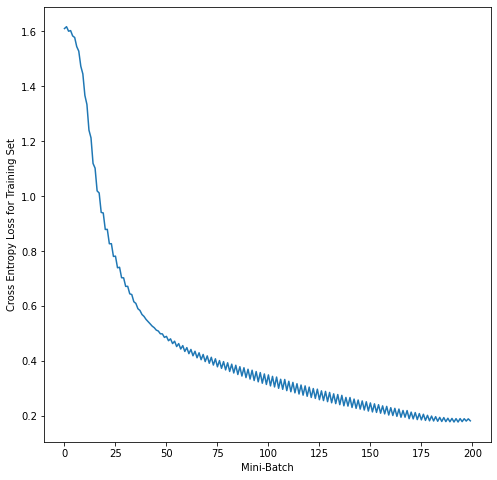

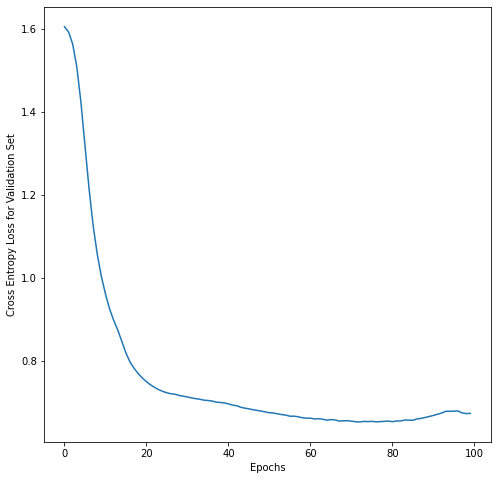

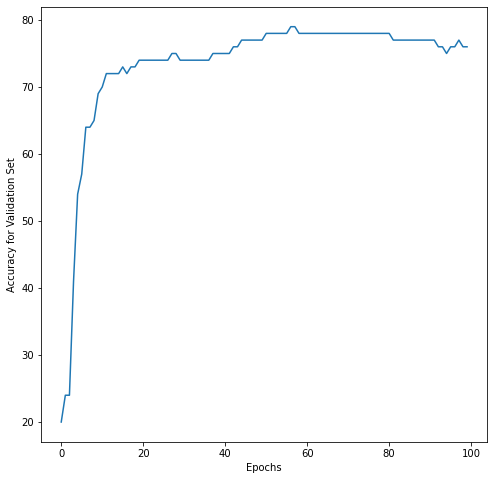

In [9]:
fig1 = plt.figure(figsize = (8,8))
training_loss = np.divide(train_loss,10)
plt.plot(training_loss)
plt.xlabel("Mini-Batch")
plt.ylabel("Cross Entropy Loss for Training Set")

'''
fig2 = plt.figure(figsize = (8,8))
training_acc = train_acc * 10 #batchsize = 10 therefore acc = sum (correct)/10 * 100
plt.plot(training_acc)
plt.xlabel("Mini-Batch")
plt.ylabel("Accuracy for Training Set")
'''


#fig2 = fig1 = plt.figure(figsize = (8,8))
#plt.plot(val_hist['val_loss'])
#print( train_loss)
fig3 = plt.figure(figsize = (8,8))
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss for Validation Set")

fig4 = plt.figure(figsize = (8,8))
plt.plot(val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy for Validation Set")

# Confusion Matrix 

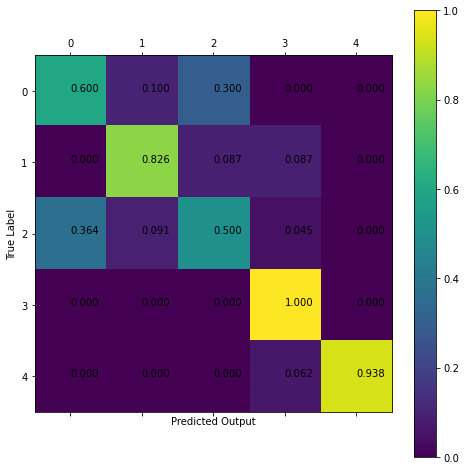

In [10]:
it = iter(val_loader)
x,y = next(it)
outputs = net(x)
_, y_pred = torch.max(outputs, 1)


#print(cm)
#print(y_pred)

fig5 = plt.figure(figsize = (8,8))
cm = confusion_matrix(y.numpy(),y_pred.numpy(), normalize = 'true')
plt.matshow(cm, fignum = 1)

for(i, j), z in np.ndenumerate(cm):
    plt.text(j,i, '{:0.3f}'.format(z))

plt.xlabel("Predicted Output")
plt.ylabel('True Label')


#plt.gca().set_xticklabels('Circle','Square','Triangle')
#plt.gca().set_yticklabels(classes)
plt.colorbar()
plt.show()

# Model Save 

In [176]:
#torch.save(net, 'ML_Proj_CNN.pth')

# Displaying Confusions as a List

In [11]:
it = iter(val_loader)
x,y = next(it)
outputs = net(x)
_, y_pred = torch.max(outputs, 1)

y = y.numpy()
y_pred = y_pred.numpy()
#print(y_pred)
#print(np.shape(y))

#y_conf = []
#y_pred_conf = []
for i in range(len(y)):
    if y_pred[i] != y[i]:
        #y_conf.append(y[i])
        #y_pred_conf.append(y_pred[i])
        print('Model confuses %1d with %1d' % (y_pred[i], y[i]))
        
#test = [1, 2, 3, 4, 5]
#comp = [1, 1, 1, 1, 5]
        
#for i in range(len(test)):
 #   if comp[i] != test[i]:
  #      print('Model confuses %1d with %1d' % (comp[i], test[i]))


Model confuses 1 with 3
Model confuses 1 with 2
Model confuses 0 with 2
Model confuses 2 with 0
Model confuses 1 with 2
Model confuses 0 with 2
Model confuses 2 with 0
Model confuses 2 with 0
Model confuses 4 with 3
Model confuses 2 with 0
Model confuses 2 with 0
Model confuses 2 with 1
Model confuses 1 with 0
Model confuses 1 with 0
Model confuses 3 with 1
Model confuses 2 with 1
Model confuses 4 with 3
Model confuses 1 with 0
